In [5]:
#Import statements

#Standard Impors
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import seaborn as sns


#Model Prep
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

#Model Types
from xgboost import XGBClassifier

#Model Accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve

#For Principal Componenet Analysis (PCA)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Cross Validating the model
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict

#Importing cleaned data
from ipynb.fs.full.ncaabwinsmodel import allgames_df2

In [6]:
# XGBoost Model
X = allgames_df2.drop(columns=['Winner'])
y = allgames_df2['Winner']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# XGBoost Model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Evaluate and print accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")


XGBoost Accuracy: 0.7372


In [7]:
# Perform cross-validation (cv=5 for 5-fold cross-validation)
cv_scores = cross_val_score(xgb, X, y, cv=5, scoring='accuracy')
y_prob_cv = cross_val_predict(xgb, X, y, cv=5, method='predict_proba')[:, 1]
y_pred_cv = cross_val_predict(xgb, X, y, cv=5)

Log Loss: 0.5164
Accuracy: 0.7372
Precision: 0.7344
Recall: 0.7361
F1 Score: 0.7353
ROC-AUC Score: 0.8211
Best Threshold by Youden’s J statistic: 0.4742


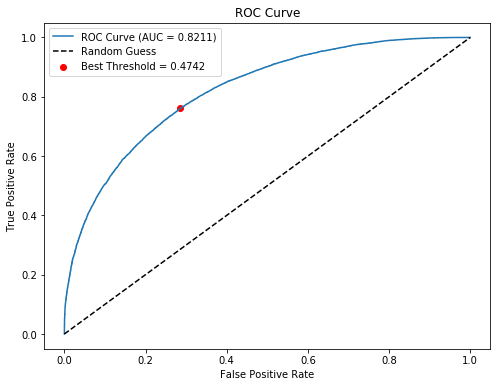

In [8]:
# Assuming your XGBoost model is trained and the predictions are generated
# Replace `xgb` with your trained XGBoost model variable if different
y_pred_test = xgb.predict(X_test)  # Predicted class labels
y_prob_test = xgb.predict_proba(X_test)[:, 1]  # Predicted probabilities for the positive class

# Calculate log loss
logloss = log_loss(y_test, y_prob_test)
print(f'Log Loss: {logloss:.4f}')

# Calculate classification-specific metrics
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.4f}')  # Correct predictions/Total Predictions
print(f'Precision: {precision:.4f}')  # True positives / Predicted positives
print(f'Recall: {recall:.4f}')  # True positives / Actual positives
print(f'F1 Score: {f1:.4f}')  # Harmonic mean of precision and recall

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_prob_test)
print(f'ROC-AUC Score: {roc_auc:.4f}')

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

# Calculate the Youden's J statistic for each threshold
j_scores = tpr - fpr
best_threshold_index = j_scores.argmax()
best_threshold = thresholds[best_threshold_index]
print(f'Best Threshold by Youden’s J statistic: {best_threshold:.4f}')

# Plot ROC Curve with the best threshold
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='red', marker='o', label=f'Best Threshold = {best_threshold:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

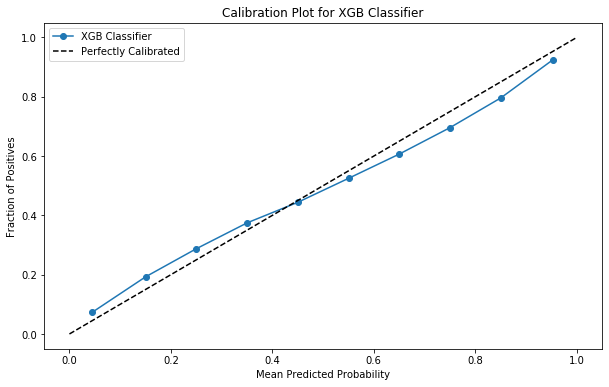

Expected Calibration Error (ECE) for XGB Classifier: 0.0344


In [9]:
# Assuming you have an XGBClassifier instance called 'xgb'
y_prob_cv_xgb = cross_val_predict(xgb, X, y, cv=5, method='predict_proba')[:, 1]

# Compute calibration curve for XGBClassifier
prob_true_xgb, prob_pred_xgb = calibration_curve(y, y_prob_cv_xgb, n_bins=10)

# Plot the calibration curve for XGBClassifier
plt.figure(figsize=(10, 6))
plt.plot(prob_pred_xgb, prob_true_xgb, marker='o', label='XGB Classifier')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.title('Calibration Plot for XGB Classifier')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

# Calculate Expected Calibration Error (ECE) for XGBClassifier
ece_xgb = np.abs(prob_true_xgb - prob_pred_xgb).mean()
print(f'Expected Calibration Error (ECE) for XGB Classifier: {ece_xgb:.4f}')